In [1]:
%connect_info

{"key":"19bf4e77-a464-43d6-8c17-4eb7bc29ad2a","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9048,"control_port":9049,"shell_port":9050,"stdin_port":9051,"iopub_port":9052,"kernel_name":"pythonjvsc74a57bd06e3d6eaeb94a86ff1e5b95ef5fac2af6d935bbec5a3c761c875ea2ca257626c9"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-68959kljEtHfVH6pM.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from torch.utils.data import IterableDataset, Dataset
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [2]:
import os

In [3]:
from dotenv import load_dotenv
load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/root/malicious-code-detection


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:

import numpy as np

In [6]:
class Config:

    BATCH_SIZE = 50
    DEVICE =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    LEARNING_RATE = 0.001
    EPOCHS = 10
    X_TEST_PATH = 'data/exp/test_token_vectors.npy'
    Y_TEST_PATH = 'data/exp/test_set_labels.txt'
    X_TRAIN_PATH = 'data/exp/train_token_vectors.npy'
    Y_TRAIN_PATH = 'data/exp/train_set_labels.txt'




X_train = np.load(Config.X_TRAIN_PATH)
y_train_str = np.loadtxt(Config.Y_TRAIN_PATH, dtype=str)
y_train = np.where(y_train_str == 'goodjs', 0.0, 1.0)
X_test = np.load(Config.X_TEST_PATH)
y_test_str = np.loadtxt(Config.Y_TEST_PATH, dtype=str)
y_test = np.where(y_test_str == 'goodjs', 0.0, 1.0)

class JSDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = JSDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, num_workers=0, drop_last=True)

test_dataset = JSDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, num_workers=0, drop_last=True)

## Bi-LSTM

In [7]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size):
        super(BiLSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim * 2, 2)  # 2 output classes
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        return (torch.zeros(2, self.batch_size, self.hidden_dim),
                torch.zeros(2, self.batch_size, self.hidden_dim))
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        return y

In [8]:
input_dim = 100  # Assuming each word vector has 100 dimensions
hidden_dim = 64  # LSTM hidden layer size
batch_size = Config.BATCH_SIZE
learning_rate = Config.LEARNING_RATE
n_epochs = Config.EPOCHS

In [9]:
model = BiLSTMModel(input_dim, hidden_dim, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Training Loop
for epoch in range(n_epochs):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.hidden = model.init_hidden()
        optimizer.zero_grad()
        
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

# Evaluation Loop
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        model.hidden = model.init_hidden()
        
        outputs = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

Accuracy: 53.644444444444446%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

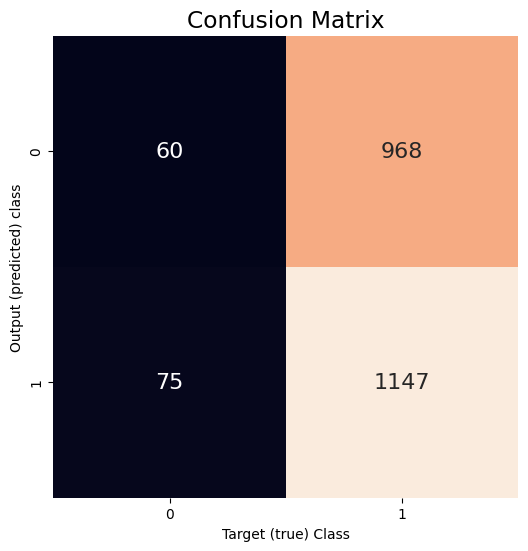

               precision    recall  f1-score   support

non-obfuscted       0.44      0.06      0.10      1028
   obfuscated       0.54      0.94      0.69      1222

     accuracy                           0.54      2250
    macro avg       0.49      0.50      0.40      2250
 weighted avg       0.50      0.54      0.42      2250



In [12]:
confusion = confusion_matrix(y_true, y_pred)

plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(confusion, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)  # font size
plt.xlabel("Target (true) Class")
plt.ylabel("Output (predicted) class")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["non-obfuscted", "obfuscated"]))